In [1]:
from tensorflow import keras
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np 
import joblib

In [8]:
def permutation_importance_by_timestep(model, X_test, y_test, metric=mean_squared_error):
	"""
	Calcula a importância de cada time step com base na permutação dos valores de ambos os canais (features).
	"""
	base_pred = model.predict(X_test, verbose = 0)
	base_score = metric(y_test, base_pred)

	timestep_importance = []

	for t in range(X_test.shape[1]):  # 80 time steps
		X_permuted = X_test.copy()
		# Permutar os valores do time step t em todas as amostras (para ambas as features)
		np.random.shuffle(X_permuted[:, t, 0])  # shuffle da feature 0 no passo t
		np.random.shuffle(X_permuted[:, t, 1])  # shuffle da feature 1 no passo t

		perm_pred = model.predict(X_permuted, verbose=0)
		perm_score = metric(y_test, perm_pred)

		importance = perm_score - base_score
		timestep_importance.append(importance)

	return np.array(timestep_importance)


def plot_timestep_importance_colored(importances):
	timesteps = np.linspace(.1, 1.5, 80)
	
	# Normaliza a importância para mapear nas cores
	norm = plt.Normalize(min(importances), max(importances))
	cmap = plt.cm.viridis
	colors = cmap(norm(importances))

	fig, ax = plt.subplots(figsize=(14, 5))  # Define o eixo principal explicitamente
	bars = ax.bar(timesteps, importances, width=.015, color=colors, edgecolor='black')

	# # Adiciona valores sobre as barras
	# for bar, val in zip(bars, importances):
	# 	if val > importances.mean():
	# 		ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
	# 				f'{val:.2f}', ha='right', va='bottom', fontsize=9, rotation=0)

	# Adiciona a colorbar corretamente vinculada ao eixo
	sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])  # Necessário para o colorbar funcionar
	cbar = fig.colorbar(sm, ax=ax)
	cbar.set_label('Importância relativa', fontdict={'fontsize':14})

	ax.set_title('Permutation Importance', fontdict={'fontsize':14})
	ax.set_xlabel('Redshift (z)', fontdict={'fontsize':14})
	ax.set_ylabel('Queda de desempenho', fontdict={'fontsize':14})
	ax.grid(True, linestyle='--', alpha=0.4)

	plt.xticks(np.linspace(.1, 1.5, 7), np.round(np.linspace(.1, 1.5, 7), 2), fontdict={'fontsize':14})

	plt.autoscale(False)
	plt.hlines(importances.mean(), 0, 1.6, colors='red', alpha=.4, linestyles='--')

	plt.tight_layout()
	plt.show()

	
def plot_timestep_importance(importances):
	plt.figure(figsize=(12, 4))
	plt.plot(np.linspace(.1, 1.5, 80), importances, marker='o')
	plt.title('Permutation Importance')
	plt.xlabel('Redshift (z)')
	plt.ylabel('Queda de desempenho')
	plt.grid(True, alpha=.3)
	plt.tight_layout()
	
	plt.xticks(np.linspace(.1, 1.5, 7), np.round(np.linspace(.1, 1.5, 7), 2))
	# plt.yticks(np.linspace(0, 2, 5), np.round(np.linspace(0, 2, 5), 2))

	plt.autoscale(False)
	plt.hlines(importances.mean(), 0, 1.6, colors='red', alpha=.4, linestyles='--')

	plt.show()





In [3]:
# Preparing the dataset and creating the features and target arrays

n_sims = 10000

x = []
y = []

for i in tqdm(range(n_sims), desc='Carregando dados', ascii=True):
	data = np.load(f'input/data_{i+1}.npy')
	x.append(data[:, :2])
	y.append(data[0, 2])  # equivalente a data[:, 2:][0][0]

x = np.array(x)
y = np.array(y)

# Normalização
y /= y.max()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

Carregando dados: 100%|##########| 10000/10000 [02:09<00:00, 77.32it/s]


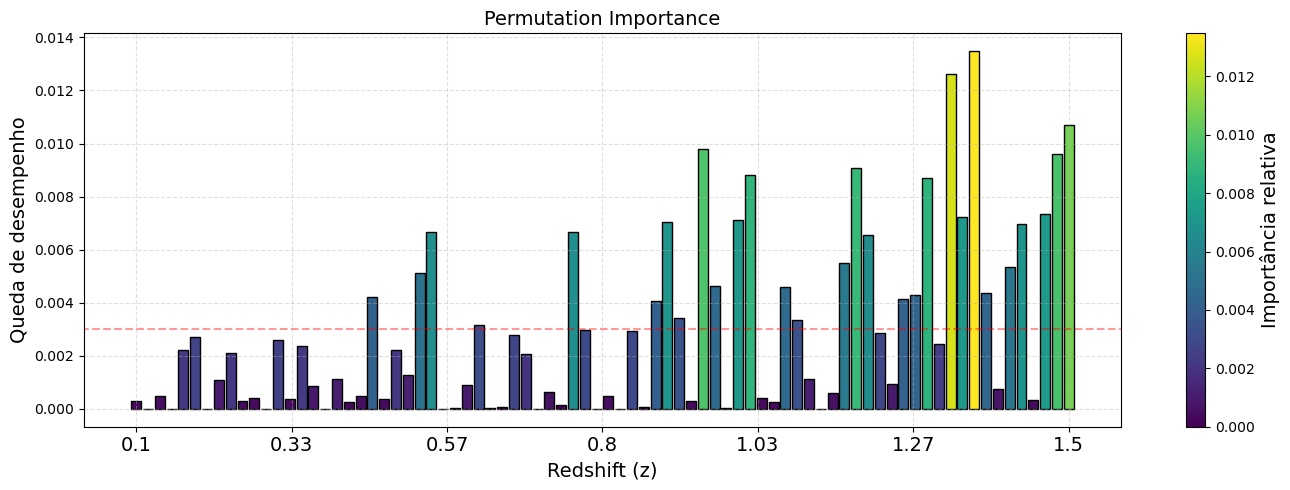

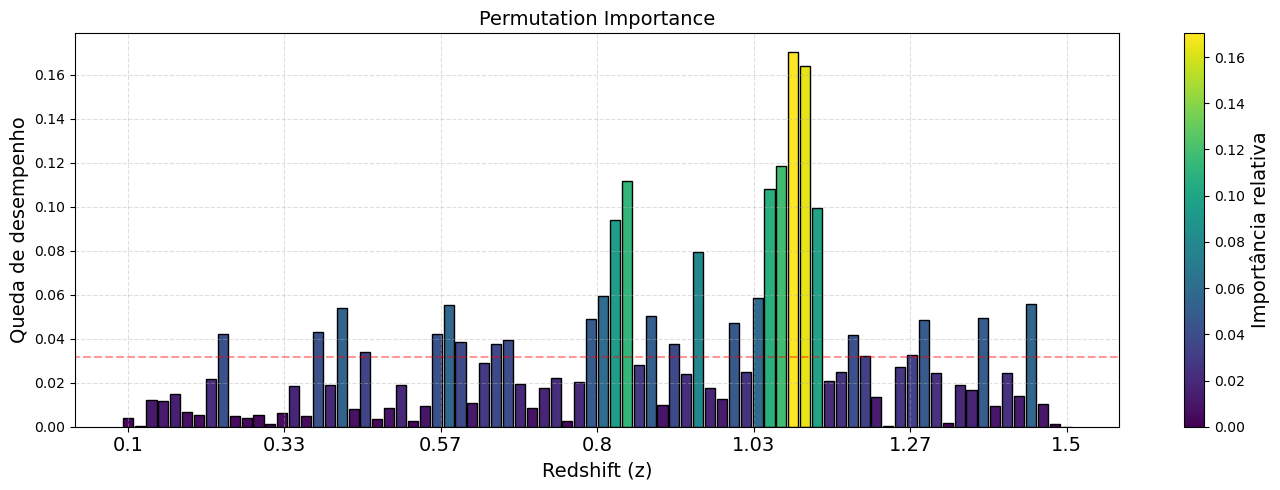

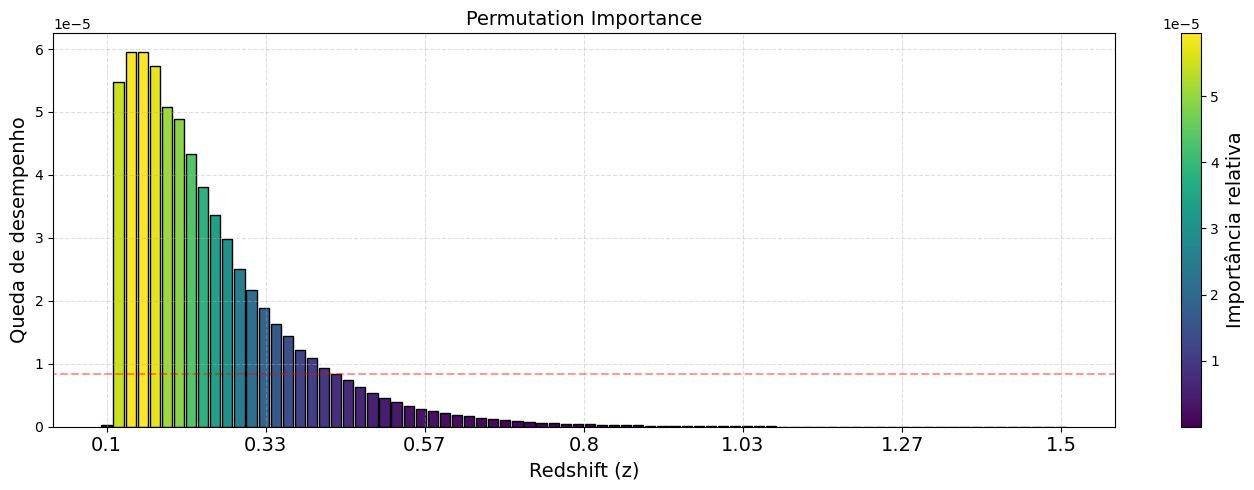

In [9]:
redes = ['dense', 'cnn', 'rnn']
# redes = ['dense', 'cnn']

for rede in redes:
		
	modelo = keras.models.load_model(f'models/{rede}')
	importances = permutation_importance_by_timestep(modelo, x, y)

	plot_timestep_importance_colored(importances)


In [13]:


model = joblib.load("models/svm.pkl")

In [ ]:
def permutation_importance_sklearn(model, X_test, y_test, metric=mean_squared_error, n_repeats=1):
	"""
	Calcula a importância de cada feature via permutação (compatível com modelos scikit-learn).
	"""
	base_pred = model.predict(X_test)
	base_score = metric(y_test, base_pred)

	importances = np.zeros(X_test.shape[1])

	for feature_idx in range(X_test.shape[1]):
		scores = []
		for _ in range(n_repeats):
			X_permuted = X_test.copy()
			np.random.shuffle(X_permuted[:, feature_idx])
			perm_pred = model.predict(X_permuted)
			perm_score = metric(y_test, perm_pred)
			scores.append(perm_score)
		importances[feature_idx] = np.mean(scores) - base_score

	return importances

In [20]:
ipt = permutation_importance_sklearn(model, x_test.reshape(2500,160), y_test)

In [18]:
x_test.reshape(2500,160)

array([[1.00000000e-01, 6.90048274e+01, 1.17721519e-01, ...,
        1.56988370e+02, 1.50000000e+00, 1.58477568e+02],
       [1.00000000e-01, 8.14988395e+01, 1.17721519e-01, ...,
        1.79266050e+02, 1.50000000e+00, 1.80938301e+02],
       [1.00000000e-01, 8.17791473e+01, 1.17721519e-01, ...,
        1.82982965e+02, 1.50000000e+00, 1.84704760e+02],
       ...,
       [1.00000000e-01, 8.09484499e+01, 1.17721519e-01, ...,
        1.80912346e+02, 1.50000000e+00, 1.82613667e+02],
       [1.00000000e-01, 7.09034461e+01, 1.17721519e-01, ...,
        1.57077741e+02, 1.50000000e+00, 1.58548399e+02],
       [1.00000000e-01, 7.77182272e+01, 1.17721519e-01, ...,
        1.71120337e+02, 1.50000000e+00, 1.72717424e+02]])

In [25]:
def plot_feature_importance_colored_sk(importances):
	"""
	Plota a importância das features com coloração baseada na magnitude.
	"""
	features = np.arange(len(importances))  # Índices das features
	
	# Normaliza a importância para mapear nas cores
	norm = plt.Normalize(min(importances), max(importances))
	cmap = plt.cm.viridis
	colors = cmap(norm(importances))

	fig, ax = plt.subplots(figsize=(14, 5))
	bars = ax.bar(features, importances, width=0.6, color=colors, edgecolor='black')

	# Adiciona a colorbar
	sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	cbar = fig.colorbar(sm, ax=ax)
	cbar.set_label('Importância (maior = mais relevante)', fontsize=12)

	ax.set_xlabel("Features", fontsize=12)
	ax.set_ylabel("Importância (Δ Erro)", fontsize=12)
	ax.set_title("Importância por Feature (Permutação)", fontsize=14)
	ax.set_xticks(features)
	ax.grid(axis='y', linestyle='--', alpha=0.6)
	
	plt.xticks(np.linspace(.1, 1.5, 7), np.round(np.linspace(.1, 1.5, 7), 2))

	plt.tight_layout()
	plt.show()

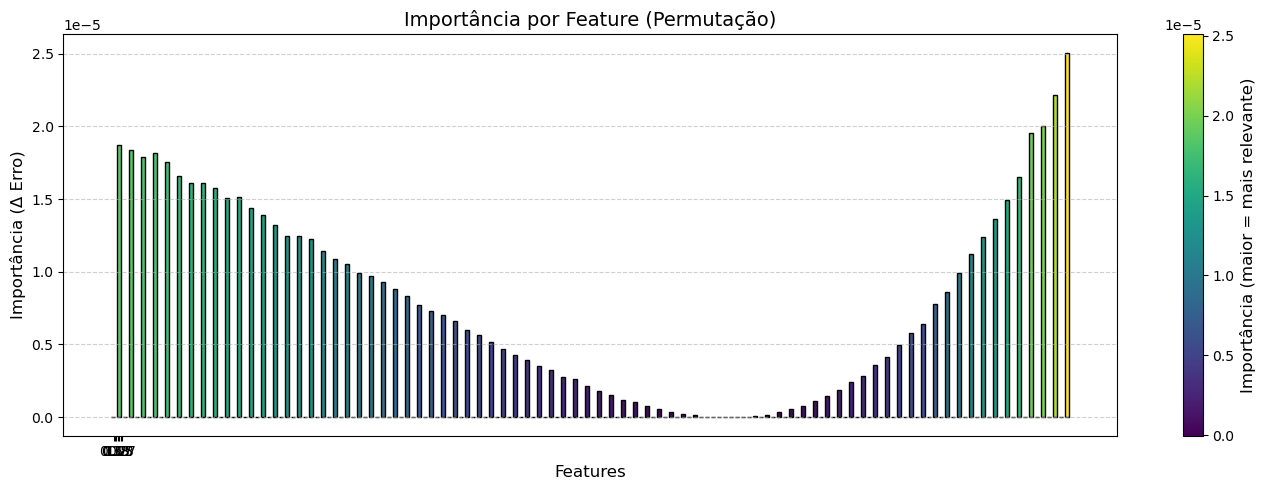

In [26]:
plot_feature_importance_colored_sk(ipt)